In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#!unzip "/content/drive/MyDrive/SI699/Code/train_100.zip" -d "/content"

In [ ]:
### train_48.zip -> training set of image size 48*48
### validation_48.zip -> validation set of image size 48*48

In [ ]:
#!pip install keras==2.6.0
#!pip install tensorflow==2.6.0

In [2]:
import tensorflow as tf
import keras
import numpy as np
import cv2
import os
# import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.layers import Dense
from keras.layers import LeakyReLU
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn import metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import KFold


In [3]:
print(tf.__version__)
print(keras.__version__)

2.12.0
2.12.0


In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Apr 18 15:38:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------


# Training Set & Testing Set

In [5]:
# Read a sample
import cv2
folder_name = '/content/100/1/'
filename = '0' + '.jpg'
img = cv2.imread(folder_name + filename, cv2.IMREAD_GRAYSCALE).reshape(100, 100, 1)
print(img.shape)

(100, 100, 1)


In [6]:
print(img[:, :, 0])

[[153 147 138 ... 174 175 177]
 [143 134 124 ... 175 177 178]
 [139 127 115 ... 178 179 180]
 ...
 [  9  11  14 ... 133 134 132]
 [  9  12  11 ... 133 133 132]
 [  6  12  10 ... 131 131 131]]


In [7]:
def readImages(folder_name, num):
    images = []
    count = 0
    for name in os.listdir(folder_name):
      try:
        img = cv2.imread(folder_name + name, cv2.IMREAD_GRAYSCALE).reshape(100, 100, 1)
      except:
        print(name)
      images.append(img)
      count += 1
      if count == num:
        break
    matrix = np.stack(images, axis=0)
    return matrix

In [8]:
images_0 = readImages('/content/100/0/', 5000)
images_1 = readImages('/content/100/1/', 5000)
images_2 = readImages('/content/100/2/', 5000)
images_3 = readImages('/content/100/3/', 5000)

.DS_Store
.DS_Store


In [9]:
print(images_0.shape)
print(images_1.shape)
print(images_2.shape)
print(images_3.shape)

(5000, 100, 100, 1)
(5000, 100, 100, 1)
(5000, 100, 100, 1)
(5000, 100, 100, 1)


In [10]:
labels_0 = np.zeros((5000,1), int)
labels_1 = np.ones((5000,1), int)
labels_2 = np.zeros((5000,1), int)
labels_2.fill(2)
labels_3 = np.zeros((5000,1), int)
labels_3.fill(3)
print(labels_0.shape)
print(labels_1.shape)
print(labels_2.shape)
print(labels_3.shape)

(5000, 1)
(5000, 1)
(5000, 1)
(5000, 1)


In [11]:
labels = np.concatenate((labels_0, labels_1, labels_2, labels_3), axis=0)
y_train_labels = to_categorical(labels)

In [12]:
images = np.vstack((images_0, images_1, images_2, images_3))

In [13]:
train_images = images.astype('float32') / 255

In [14]:
print(train_images.shape)
print(y_train_labels.shape)

(20000, 100, 100, 1)
(20000, 4)


# Validation Set

In [ ]:
#!unzip "/content/drive//MyDrive/SI699/Code/Validation_100.zip" -d "/content"

In [15]:
count = 500

In [16]:
images_val_0 = readImages('/content/Validation_100/0/', count)
images_val_1 = readImages('/content/Validation_100/1/', count)
images_val_2 = readImages('/content/Validation_100/2/', count)
images_val_3 = readImages('/content/Validation_100/3/', count)

In [17]:
validation_images = np.vstack((images_val_0, images_val_1, images_val_2, images_val_3))
val_images = validation_images.astype('float32') / 255

In [18]:
labels_val_0 = np.zeros((count,1), int)
labels_val_1 = np.ones((count,1), int)
labels_val_2 = np.zeros((count,1), int)
labels_val_2.fill(2)
labels_val_3 = np.zeros((count,1), int)
labels_val_3.fill(3)
print(labels_val_0.shape)
print(labels_val_1.shape)
print(labels_val_2.shape)
print(labels_val_3.shape)

(500, 1)
(500, 1)
(500, 1)
(500, 1)


In [19]:
print(val_images.shape)

(2000, 100, 100, 1)


In [20]:
val_labels = np.concatenate((labels_val_0, labels_val_1, labels_val_2, labels_val_3), axis=0)

In [21]:
y_val_labels = to_categorical(val_labels)


In [22]:
print(train_images.shape)
print(y_train_labels.shape)
print(val_images.shape)
print(y_val_labels.shape)

(20000, 100, 100, 1)
(20000, 4)
(2000, 100, 100, 1)
(2000, 4)


# CNN 1

In [27]:
# CNN
cnn1 = models.Sequential()
cnn1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)))
cnn1.add(layers.MaxPooling2D((2, 2)))
cnn1.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn1.add(layers.MaxPooling2D((2, 2)))
cnn1.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn1.add(layers.Flatten())
cnn1.add(layers.Dense(64, activation='relu'))
cnn1.add(layers.Dense(4, activation='softmax'))

cnn1.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')


In [28]:
#https://www.kaggle.com/code/franklemuchahary/basic-cnn-keras-with-cross-validation
#set early stopping criteria
pat = 5 #this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

#define the model checkpoint callback -> this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('fas_mnist_1.h5', verbose=1, save_best_only=True)

In [ ]:
#https://www.kaggle.com/code/franklemuchahary/basic-cnn-keras-with-cross-validation
n_folds=3
epochs=20
batch_size=128

model_history = [] 

#split data
for i in range(n_folds):
    print("Training on Fold: ",i+1)
    #split data
    train_X, test_X, train_y, test_y = train_test_split(train_images, 
                                              y_train_labels, 
                                              test_size=0.2, 
                                              shuffle = True)
    #evaluate model
    model_history.append(cnn1.fit(train_X, 
                                   train_y, 
                                   validation_data = (test_X, test_y),
                                   epochs=epochs, 
                                   batch_size=batch_size, 
                                   #callbacks=[early_stopping, model_checkpoint], 
                                   verbose=1))
    
    print("Test Score: ", cnn1.evaluate(test_X, test_y))

In [ ]:
test_loss, test_acc = cnn1.evaluate(val_images, y_val_labels)

63/63 [==============================] - 1s 10ms/step - loss: 2.5361 - accuracy: 0.5900


In [77]:
predictions = cnn1.predict(val_images)

63/63 [==============================] - 0s 5ms/step


In [25]:
def plotConfusionMatrix(predictions):
  y_pred=np.argmax(predictions, axis=1)
  y_test=np.argmax(y_val_labels, axis=1)

  confusion_matrix = metrics.confusion_matrix(y_pred, y_test, normalize='true')

  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=["0", "1", "2", "3"])
  disp.plot()

  plt.show()

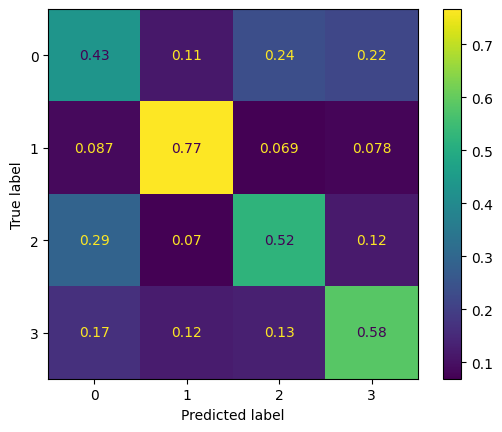

In [79]:
plotConfusionMatrix(predictions)

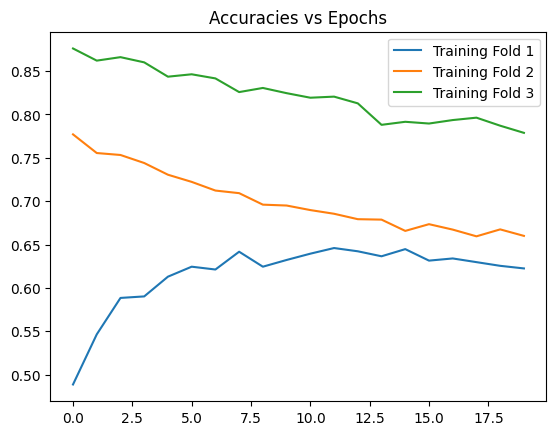

In [80]:
plt.title('Accuracies vs Epochs')
plt.plot(model_history[0].history['val_accuracy'], label='Training Fold 1')
plt.plot(model_history[1].history['val_accuracy'], label='Training Fold 2')
plt.plot(model_history[2].history['val_accuracy'], label='Training Fold 3')
plt.legend()
plt.show()

# CNN 2

In [40]:
cnn2 = models.Sequential()
cnn2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)))
cnn2.add(layers.MaxPooling2D((2, 2)))
cnn2.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn2.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn2.add(layers.MaxPooling2D((2, 2)))
cnn2.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn2.add(layers.Conv2D(64, (3, 3), activation='relu'))

cnn2.add(layers.Flatten())
cnn2.add(layers.Dense(64, activation='relu'))
cnn2.add(layers.Dense(4, activation='softmax'))

cnn2.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')


In [ ]:
#https://www.kaggle.com/code/franklemuchahary/basic-cnn-keras-with-cross-validation
n_folds=3
epochs=20
batch_size=128

model_history2 = [] 

#split data
for i in range(n_folds):
    print("Training on Fold: ",i+1)
    #split data
    train_X, test_X, train_y, test_y = train_test_split(train_images, 
                                              y_train_labels, 
                                              test_size=0.2, 
                                              shuffle = True)
    #evaluate model
    model_history2.append(cnn2.fit(train_X, 
                                   train_y, 
                                   validation_data = (test_X, test_y),
                                   epochs=epochs, 
                                   batch_size=batch_size, 
                                   #callbacks=[early_stopping, model_checkpoint], 
                                   verbose=1))
    
    print("Test Score: ", cnn2.evaluate(test_X, test_y))

In [71]:
test_loss, test_acc = cnn1.evaluate(val_images, y_val_labels)

63/63 [==============================] - 1s 9ms/step - loss: 4.5488 - accuracy: 0.5695


In [81]:
predictions2 = cnn2.predict(val_images)

63/63 [==============================] - 0s 5ms/step


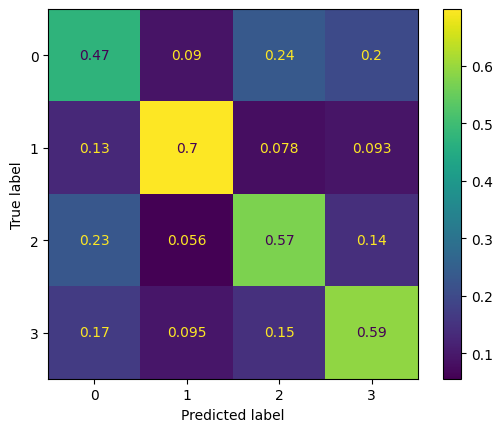

In [82]:
plotConfusionMatrix(predictions2)

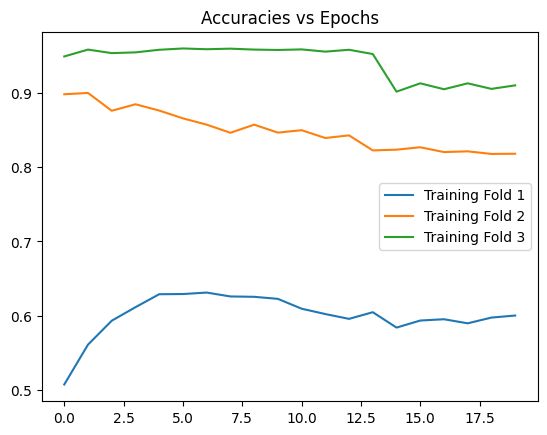

In [58]:
plt.title('Accuracies vs Epochs')
plt.plot(model_history2[0].history['val_accuracy'], label='Training Fold 1')
plt.plot(model_history2[1].history['val_accuracy'], label='Training Fold 2')
plt.plot(model_history2[2].history['val_accuracy'], label='Training Fold 3')
plt.legend()
plt.show()

# CNN 3

In [23]:
cnn3 = models.Sequential()
cnn3.add(layers.Conv2D(32, (6, 6), activation='relu', input_shape=(100, 100, 1)))

cnn3.add(layers.MaxPooling2D((2, 2)))
cnn3.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn3.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn3.add(layers.MaxPooling2D((2, 2)))
cnn3.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn3.add(layers.Conv2D(128, (3, 3), activation='relu'))

cnn3.add(layers.Flatten())
cnn3.add(layers.Dense(64, activation='relu'))
cnn3.add(layers.Dense(64, activation='relu'))
cnn3.add(layers.Dense(4, activation='softmax'))

cnn3.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')


In [24]:
#https://www.kaggle.com/code/franklemuchahary/basic-cnn-keras-with-cross-validation
n_folds=3
epochs=20
batch_size=128

model_history3 = [] 

#split data
for i in range(n_folds):
    print("Training on Fold: ",i+1)
    #split data
    train_X, test_X, train_y, test_y = train_test_split(train_images, 
                                              y_train_labels, 
                                              test_size=0.2, 
                                              shuffle = True)
    #evaluate model
    model_history3.append(cnn3.fit(train_X, 
                                   train_y, 
                                   validation_data = (test_X, test_y),
                                   epochs=epochs, 
                                   batch_size=batch_size, 
                                   #callbacks=[early_stopping, model_checkpoint], 
                                   verbose=1))
    
    print("Test Score: ", cnn3.evaluate(test_X, test_y))

Training on Fold:  1
Epoch 1/20
125/125 [==============================] - 22s 60ms/step - loss: 1.3869 - accuracy: 0.2451 - val_loss: 1.3851 - val_accuracy: 0.3002
Epoch 2/20
125/125 [==============================] - 6s 50ms/step - loss: 1.3161 - accuracy: 0.3520 - val_loss: 1.1727 - val_accuracy: 0.4633
Epoch 3/20
125/125 [==============================] - 6s 49ms/step - loss: 1.0946 - accuracy: 0.5218 - val_loss: 1.0321 - val_accuracy: 0.5455
Epoch 4/20
125/125 [==============================] - 6s 50ms/step - loss: 0.9862 - accuracy: 0.5759 - val_loss: 0.9839 - val_accuracy: 0.5720
Epoch 5/20
125/125 [==============================] - 6s 51ms/step - loss: 0.9215 - accuracy: 0.6117 - val_loss: 0.9325 - val_accuracy: 0.6000
Epoch 6/20
125/125 [==============================] - 6s 50ms/step - loss: 0.8644 - accuracy: 0.6379 - val_loss: 0.8865 - val_accuracy: 0.6360
Epoch 7/20
125/125 [==============================] - 6s 50ms/step - loss: 0.8190 - accuracy: 0.6617 - val_loss: 0.9040 

In [26]:
test_loss, test_acc = cnn3.evaluate(val_images, y_val_labels)

63/63 [==============================] - 1s 11ms/step - loss: 4.1305 - accuracy: 0.5900


In [27]:
predictions3 = cnn3.predict(val_images)

63/63 [==============================] - 1s 6ms/step


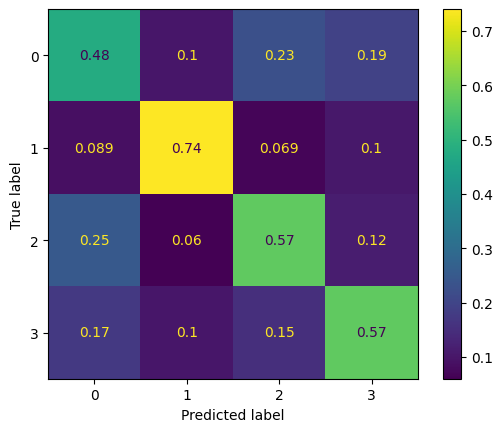

In [28]:
plotConfusionMatrix(predictions3)

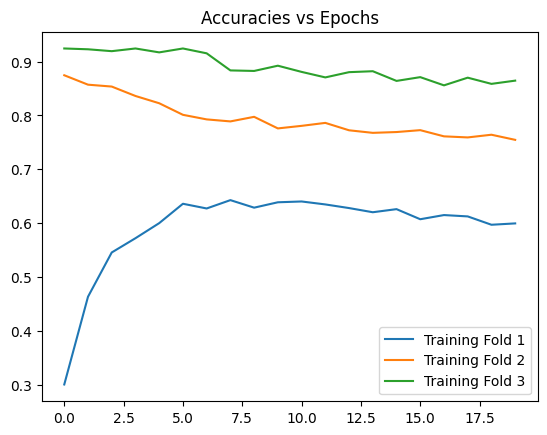

In [29]:
plt.title('Accuracies vs Epochs')
plt.plot(model_history3[0].history['val_accuracy'], label='Training Fold 1')
plt.plot(model_history3[1].history['val_accuracy'], label='Training Fold 2')
plt.plot(model_history3[2].history['val_accuracy'], label='Training Fold 3')
plt.legend()
plt.show()

# CNN 4

In [42]:
cnn4 = models.Sequential()
cnn4.add(layers.Conv2D(32, (6, 6), activation='relu', input_shape=(100, 100, 1)))
cnn4.add(LeakyReLU(alpha=0.1))
cnn4.add(layers.MaxPooling2D((2, 2)))
cnn4.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn4.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn4.add(LeakyReLU(alpha=0.1))
cnn4.add(layers.MaxPooling2D((2, 2)))
cnn4.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn4.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn4.add(LeakyReLU(alpha=0.1))

cnn4.add(layers.Flatten())

cnn4.add(layers.Dense(64))
cnn4.add(layers.Dense(64))
cnn4.add(LeakyReLU(alpha=0.1))

cnn4.add(layers.Dense(4, activation='softmax'))

cnn4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [43]:
#https://www.kaggle.com/code/franklemuchahary/basic-cnn-keras-with-cross-validation
n_folds=3
epochs=20
batch_size=128

model_history4 = [] 

#split data
for i in range(n_folds):
    print("Training on Fold: ",i+1)
    #split data
    train_X, test_X, train_y, test_y = train_test_split(train_images, 
                                              y_train_labels, 
                                              test_size=0.2, 
                                              shuffle = True)
    #evaluate model
    model_history4.append(cnn4.fit(train_X, 
                                   train_y, 
                                   validation_data = (test_X, test_y),
                                   epochs=epochs, 
                                   batch_size=batch_size, 
                                   #callbacks=[early_stopping, model_checkpoint], 
                                   verbose=1))
    
    print("Test Score: ", cnn4.evaluate(test_X, test_y))

Training on Fold:  1
Epoch 1/20
125/125 [==============================] - 10s 63ms/step - loss: 1.3553 - accuracy: 0.3199 - val_loss: 1.2371 - val_accuracy: 0.4415
Epoch 2/20
125/125 [==============================] - 7s 59ms/step - loss: 1.1475 - accuracy: 0.4864 - val_loss: 1.0890 - val_accuracy: 0.5138
Epoch 3/20
125/125 [==============================] - 7s 59ms/step - loss: 1.0391 - accuracy: 0.5515 - val_loss: 1.0173 - val_accuracy: 0.5520
Epoch 4/20
125/125 [==============================] - 7s 59ms/step - loss: 0.9634 - accuracy: 0.5906 - val_loss: 0.9426 - val_accuracy: 0.5962
Epoch 5/20
125/125 [==============================] - 7s 59ms/step - loss: 0.8951 - accuracy: 0.6195 - val_loss: 0.9185 - val_accuracy: 0.6143
Epoch 6/20
125/125 [==============================] - 7s 59ms/step - loss: 0.8475 - accuracy: 0.6457 - val_loss: 0.9004 - val_accuracy: 0.6308
Epoch 7/20
125/125 [==============================] - 7s 59ms/step - loss: 0.7904 - accuracy: 0.6721 - val_loss: 0.8991 

In [44]:
test_loss, test_acc = cnn4.evaluate(val_images, y_val_labels)

63/63 [==============================] - 1s 9ms/step - loss: 4.3542 - accuracy: 0.5710


63/63 [==============================] - 0s 6ms/step


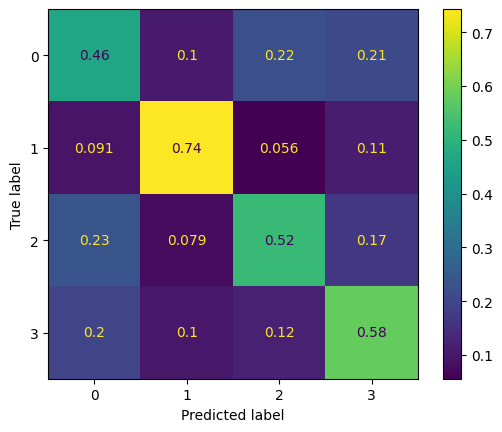

In [45]:
predictions4 = cnn4.predict(val_images)
plotConfusionMatrix(predictions4)

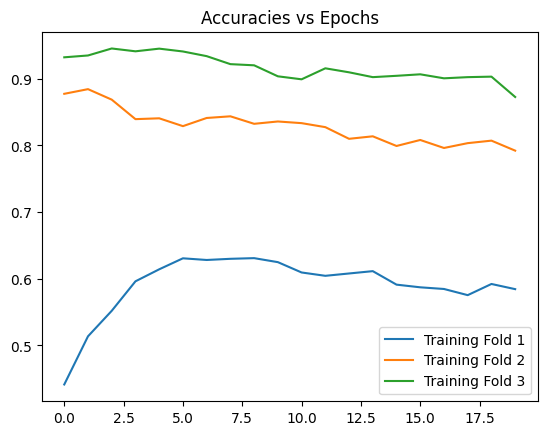

In [46]:
plt.title('Accuracies vs Epochs')
plt.plot(model_history4[0].history['val_accuracy'], label='Training Fold 1')
plt.plot(model_history4[1].history['val_accuracy'], label='Training Fold 2')
plt.plot(model_history4[2].history['val_accuracy'], label='Training Fold 3')
plt.legend()
plt.show()

In [ ]:
# model.save('baseline_model.h5')
# model_test.save('baseline_model.h5')
# modelN.save('baseline_model.h5')